In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import sys

sys.path.append("../..")

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sns

import src.datasets.loading.ookla
import src.datasets.loading.statcan
import src.datasets.joins

from src.config import DATA_DIRECTORY

In [2]:
das_info = gp.read_file(DATA_DIRECTORY / "hackathon" / "geometry.gpkg", driver="GPKG")
speed_data = pd.read_csv(DATA_DIRECTORY / "hackathon" / "speeds.csv")
speed_data.DAUID = speed_data.DAUID.astype(str)

In [10]:
full_data = pd.merge(das_info, speed_data)
full_data["date"] = pd.to_datetime(
    full_data["year"].astype(str)
    + "-"
    + ((full_data["quarter"] - 1) * 3 + 1).astype(str)
    + "-01"
)

In [11]:
# Look at statistics from particular cities
# calgary_avg_d_kbps = (
#     full_data.loc[lambda s: s.PCNAME.isin(["Calgary"])]
#     .groupby(["PCNAME", "year", "quarter"])["avg_d_kbps"]
#     .aggregate(["mean", "std", "min", "max"])
# ).reset_index()
# calgary_avg_d_kbps["date"] = pd.to_datetime(
#     calgary_avg_d_kbps["year"].astype(str)
#     + "-"
#     + ((calgary_edmonton_avg_d_kbps["quarter"] - 1) * 3 + 1).astype(str)
#     + "-01"
# )
# calgary_avg_d_kbps
# # Look at statistics from particular cities
# edmonton_avg_d_kbps = (
#     full_data.loc[lambda s: s.PCNAME.isin(["Edmonton"])]
#     .groupby(["PCNAME", "year", "quarter"])["avg_d_kbps"]
#     .aggregate(["mean", "std", "min", "max"])
# ).reset_index()
# edmonton_avg_d_kbps["date"] = pd.to_datetime(
#     edmonton_avg_d_kbps["year"].astype(str)
#     + "-"
#     + ((edmonton_avg_d_kbps["quarter"] - 1) * 3 + 1).astype(str)
#     + "-01"
# )
# edmonton_avg_d_kbps
# # calgary_avg_d_kbps
full_data.set_index('date', inplace=True)

# 使用 resample 方法按季度分组，并计算平均值
quarterly_mean = full_data['avg_d_kbps'].resample('Q').median()
print(quarterly_mean.dropna(how="any"))

date
2019-03-31     71209.000000
2019-06-30     71403.700000
2019-09-30     76513.916667
2019-12-31     85045.150000
2020-03-31     89614.500000
2020-06-30     92834.000000
2020-09-30     95131.000000
2020-12-31    105980.600000
2021-03-31    112243.000000
2021-06-30    122339.000000
2021-09-30    122299.000000
2021-12-31    128738.125000
2022-03-31    138514.666667
2022-06-30    133296.000000
2022-09-30    131715.000000
2022-12-31    148866.250000
2023-03-31    162068.666667
2023-06-30    160173.461538
Freq: Q-DEC, Name: avg_d_kbps, dtype: float64


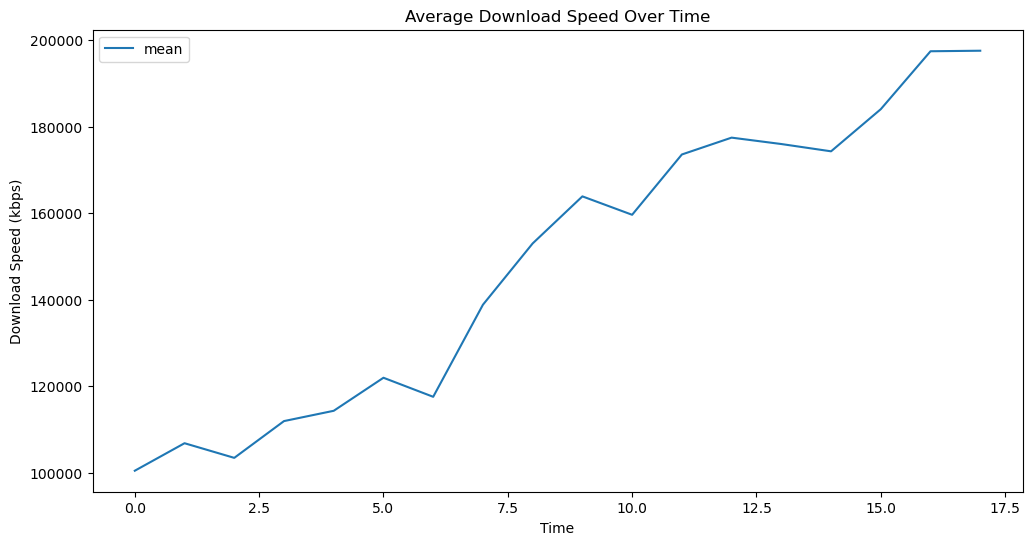

In [37]:
data_cal = calgary_avg_d_kbps[['mean']][:18]
data_edm = edmonton_avg_d_kbps[['mean']][:18]
data_cal.plot(figsize=(12, 6))
plt.title('Average Download Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Download Speed (kbps)')
plt.show()

ADF Statistic: -5.837335
p-value: 0.000000
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682


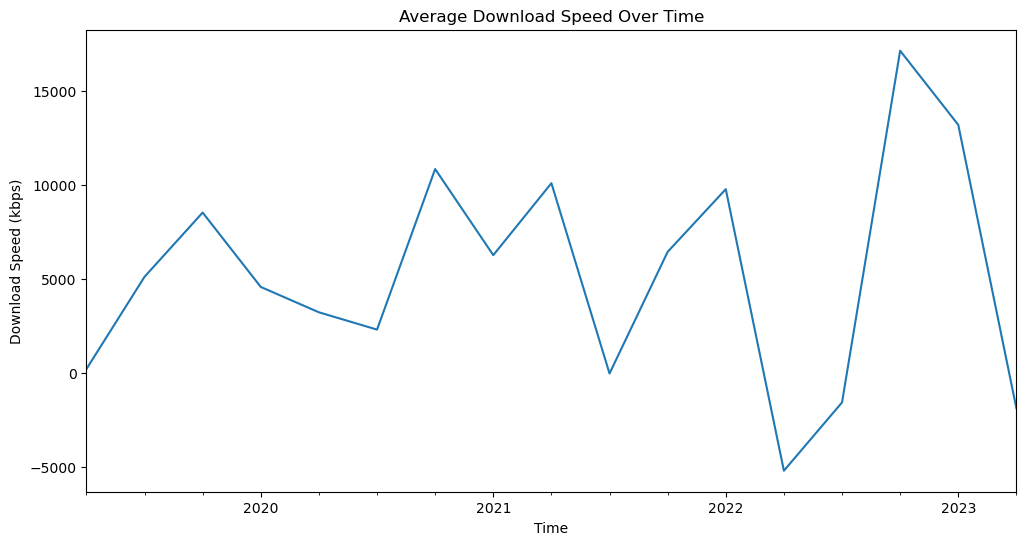

In [18]:
#stationary test
from statsmodels.tsa.stattools import adfuller
# data_c = data_cal.diff(periods=1)[1:]
# data_e = data_edm.diff(periods=1)[1:]
d = data.diff(periods=1)[1:]
#Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
result = adfuller(d)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

# result = adfuller(data_e)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

d.plot(figsize=(12, 6))
plt.title('Average Download Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Download Speed (kbps)')
plt.show()

In [57]:
#white noise test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data_c, lags = [i for i in range(1,17)],boxpierce=True)
import warnings
warnings.filterwarnings("ignore")

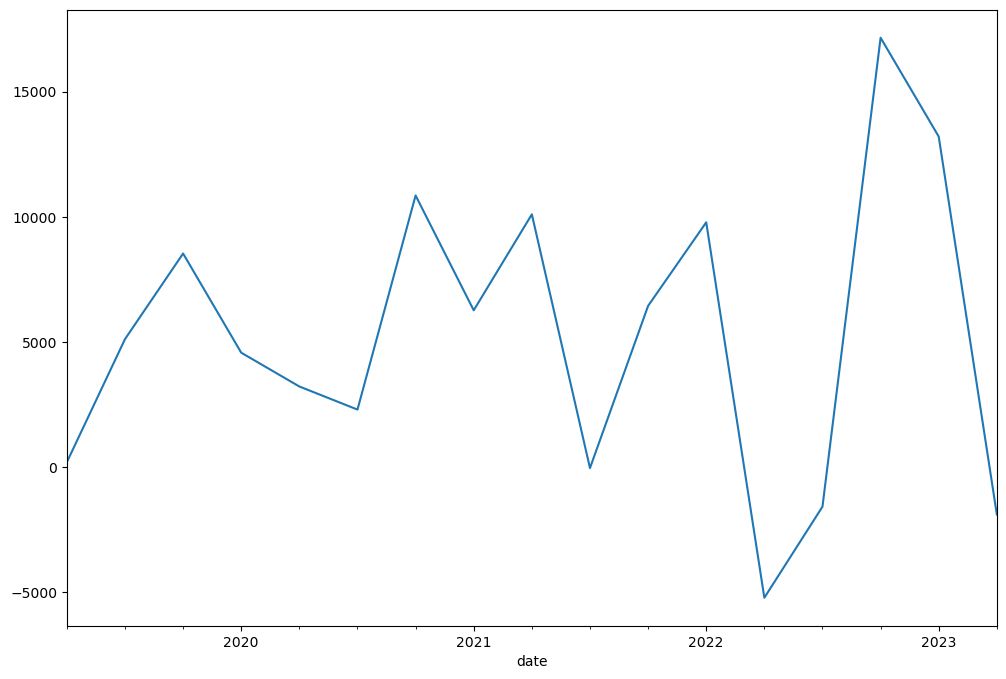

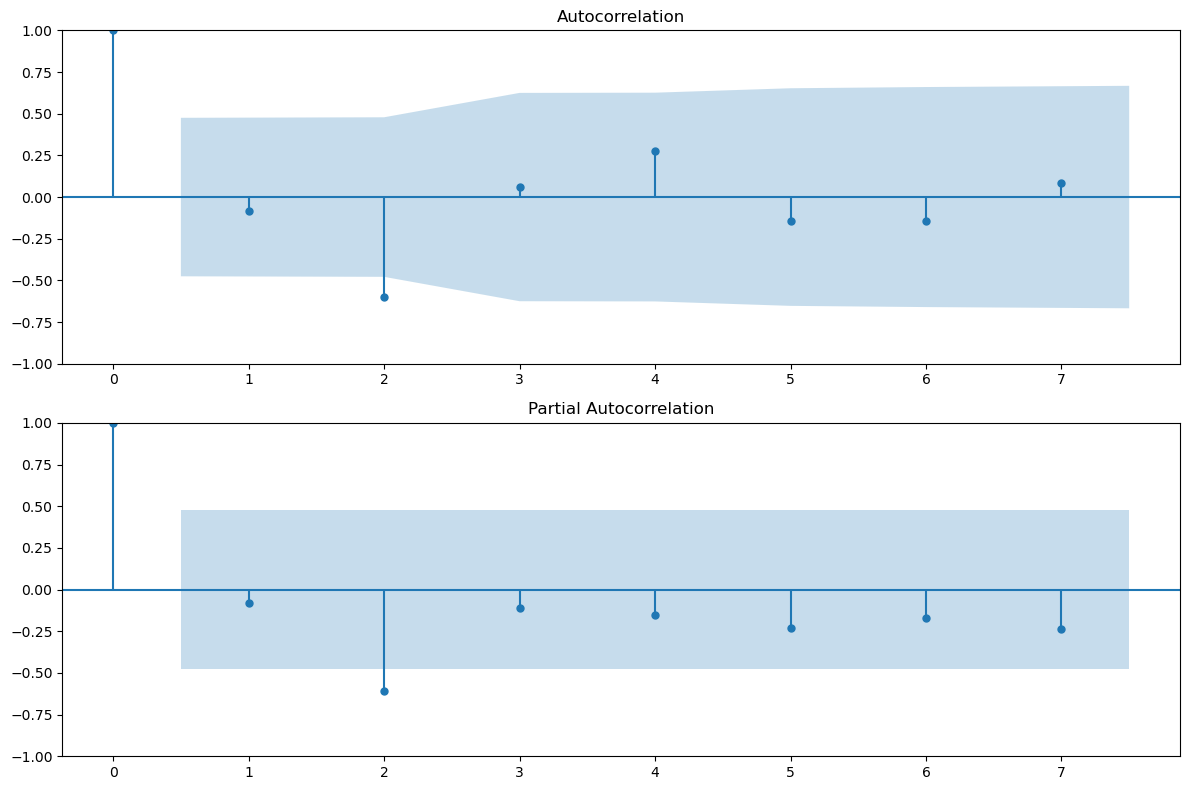

In [15]:
#ACF & PACF
# plt.rcParams['font.sans-serif'] = ['sans-serif']
import warnings
warnings.filterwarnings("ignore")
def draw_acf_pacf(data):
    data.plot(figsize=(12,8))
    # plt.legend(bbox_to_anchor=(1.25, 0.5))
    # plt.title("emm")
    fig = plt.figure(figsize=(12,8))    


    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=7,ax=ax1)
    ax1.xaxis.set_ticks_position('bottom')
    fig.tight_layout();

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=7, ax=ax2)
    ax2.xaxis.set_ticks_position('bottom')
    fig.tight_layout();
draw_acf_pacf(data.diff(periods=1)[1:])   


In [67]:
#ARIMA Model
data = calgary_avg_d_kbps[['mean']]
data = data[:18]
model = ARIMA(data_cal, order=(4, 1, 6))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

18    199699.867066
dtype: float64


In [13]:
#another way to select order
def get_pq(data):
    #AIC
    AIC = sm.tsa.arma_order_select_ic(data, max_ar=7, max_ma=7, ic='aic')['aic_min_order']
    #BIC
    BIC = sm.tsa.arma_order_select_ic(data, max_ar=7, max_ma=7, ic='bic')['bic_min_order']
    print('the AIC is{},\nthe BIC is{}\n'.format(AIC,BIC))
data = quarterly_mean.dropna(how="any")
get_pq(data.diff(periods=1)[1:])


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

the AIC is(3, 3),
the BIC is(3, 3)



/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [88]:
print(calgary_avg_d_kbps[:-1])

     PCNAME  year  quarter           mean           std    min       max  \
0   Calgary  2019        1  100435.783052  48010.233544  162.0  554719.0   
1   Calgary  2019        2  106797.181026  54944.183893   17.0  605889.0   
2   Calgary  2019        3  103409.917330  47027.075159  118.0  437692.0   
3   Calgary  2019        4  111916.628759  51070.855608   52.0  503773.0   
4   Calgary  2020        1  114299.150983  49609.178289  193.0  510157.0   
5   Calgary  2020        2  121940.746970  55186.145875   58.0  577982.0   
6   Calgary  2020        3  117533.857017  50023.054660   87.0  442587.0   
7   Calgary  2020        4  138831.303694  60977.463773  462.0  615662.0   
8   Calgary  2021        1  153009.023423  63249.454112  939.0  492154.0   
9   Calgary  2021        2  163894.500128  72610.473648  314.0  641328.0   
10  Calgary  2021        3  159637.373152  75616.822241   44.0  510118.0   
11  Calgary  2021        4  173583.613467  73199.391434  261.0  709299.0   
12  Calgary 

findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: 

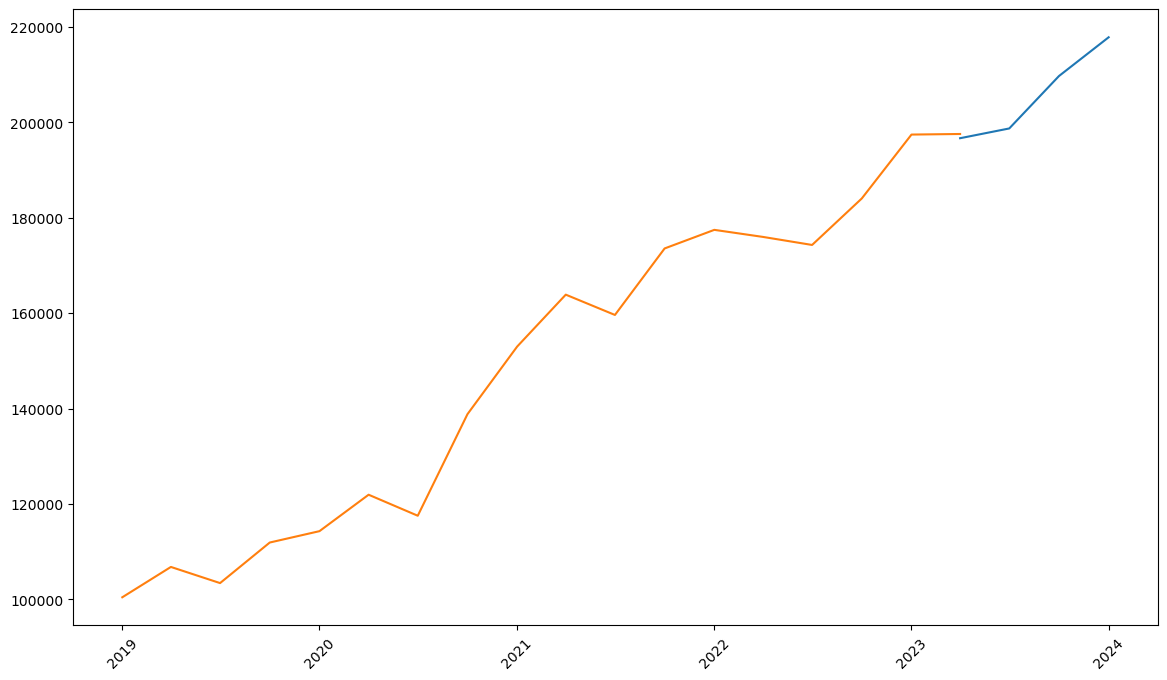

In [91]:
#predict
datac = calgary_avg_d_kbps[:18].set_index('date', inplace=False)
def predict(data, order, start, end, freq=None):
    model = ARIMA(data, order=order, freq=freq)
    result = model.fit()
    pred = result.predict(start, end, dynamic=True, typ='levels')
    plt.figure(figsize=(14, 8))
    plt.xticks(rotation=45)
    plt.plot(pred)
    plt.plot(data)
    return pred


pred_month = predict(datac[['mean']], (4, 1, 6), '2023-04-01', '2023-12-01')
# pred_month.to_csv("demo1.csv")


In [20]:
#SARIMA MODEL
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

18    202861.899555
dtype: float64


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
